In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/4sq/input/

lgb_012.lgb	       train.csv	   train_data_1_1.zip  train_data3.csv
lgb_01.lgb	       train_data_0_1.csv  train_data_1_2.csv  train_data4.csv
lgb_02.lgb	       train_data_0_2.csv  train_data_1_3.csv  train_data5.csv
lgb_12.lgb	       train_data_0_3.csv  train_data_1_4.csv  tv_ids_d.npy
pairs.csv	       train_data_0_4.csv  train_data_1_5.csv
sample_submission.csv  train_data_0_5.csv  train_data1.csv
test.csv	       train_data_1_1.csv  train_data2.csv


In [4]:
!python -m pip install "dask[complete]"
! pip3 install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import time
import random
import difflib
import multiprocessing
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import dask.dataframe as dd

In [6]:
input_type = {
'id':                    'object',
'match_id':              'object',
'kdist':                 'float32',
'kneighbors':            'float32',
'kdist_country':         'float32',
'latdiff':                 'float32',
'londiff':                 'float32',
'manhattan':            'float32',
'euclidean':              'float32',
'haversine':              'float32',
'kneighbors_country':    'float32',
'label':                 'bool',
'name_sim':              'float32',
'name_gesh':             'float32',
'name_leven':            'float32',
'name_jaro':             'float32',
'name_lcs':              'float32',
'name_len_diff':         'uint8',
'name_nleven':           'float32',
'name_nlcsk':            'float32',
'name_nlcs':             'float32',
'address_sim':           'float32',
'address_gesh':          'float32',
'address_leven':         'float32',
'address_jaro':          'float32',
'address_lcs':           'float32',
'address_len_diff':      'uint8',
'address_nleven':        'float32',
'address_nlcsk':         'float32',
'address_nlcs':          'float32',
'city_gesh':             'float32',
'city_leven':            'float32',
'city_jaro':             'float32',
'city_lcs':              'float32',
'city_len_diff':         'uint8',
'city_nleven':           'float32',
'city_nlcsk':            'float32',
'city_nlcs':             'float32',
'state_sim':             'float32',
'state_gesh':            'float32',
'state_leven':           'float32',
'state_jaro':            'float32',
'state_lcs':             'float32',
'state_len_diff':        'uint8',
'state_nleven':          'float32',
'state_nlcsk':           'float32',
'state_nlcs':            'float32',
'zip_gesh':              'float32',
'zip_leven':             'float32',
'zip_jaro':              'float32',
'zip_lcs':               'float32',
'url_sim':               'float32',
'url_gesh':              'float32',
'url_leven':             'float32',
'url_jaro':              'float32',
'url_lcs':               'float32',
'url_len_diff':          'uint8',
'url_nleven':            'float32',
'url_nlcsk':             'float32',
'url_nlcs':              'float32',
'phone_gesh':            'float32',
'phone_leven':           'float32',
'phone_jaro':            'float32',
'phone_lcs':             'float32',
'categories_sim':        'float32',
'categories_gesh':       'float32',
'categories_leven':      'float32',
'categories_jaro':       'float32',
'categories_lcs':        'float32',
'categories_len_diff':   'uint8',
'categories_nleven':     'float32',
'categories_nlcsk':      'float32',
'categories_nlcs':       'float32',
'country_sim':           'float32',
'country_gesh':          'float32',
'country_leven':         'float32',
'country_jaro':          'float32',
'country_lcs':           'float32',
'country_len_diff':      'bool',
'country_nleven':        'float32',
'country_nlcsk':         'float32',
'country_nlcs':          'float32',
'kdist_diff':            'float32',
'kneighbors_mean':       'float32',
'country_x':             'category',
'country_y':             'category',
'latitude_x':            'float32',
'latitude_y':            'float32',
'longitude_x':            'float32',
'longitude_y':            'float32',
}
cat_list = ['country_x', 'country_y']

In [7]:
!ls drive/MyDrive/4sq/input/train_data1.csv

drive/MyDrive/4sq/input/train_data1.csv


In [8]:
train_list = [dd.read_csv(f'drive/MyDrive/4sq/input/train_data_0_{i}.csv', dtype=input_type).compute() for i in range(1,6)]
#train_list = [dd.read_csv(f'drive/MyDrive/4sq/input/train_data_1_{i}.csv', dtype=input_type).compute() for i in range(1,6)]

In [9]:
# 0,1,2,3,4
cv = 0
train = pd.concat([train_list[cv], train_list[(cv+1)%5], train_list[(cv+2)%5], train_list[(cv+3)%5], train_list[(cv+4)%5]], ignore_index=True)
#train = pd.concat([train_list[cv], train_list[(cv+1)%5], train_list[(cv+2)%5]], ignore_index=True)

valid = dd.read_csv('drive/MyDrive/4sq/input/train_data_1_1.csv', dtype=input_type).compute() 
#valid = dd.read_csv('drive/MyDrive/4sq/input/train_data_0_1.csv', dtype=input_type).compute() 

del train_list
gc.collect()

0

In [10]:
# importanceの低い素性を削る
train = train.drop(['country_jaro', 'country_nlcsk', 'country_lcs', 'country_len_diff', 'country_nlcs', 'country_nleven', 'country_leven'], axis=1)
valid = valid.drop(['country_jaro', 'country_nlcsk', 'country_lcs', 'country_len_diff', 'country_nlcs', 'country_nleven', 'country_leven'], axis=1)

In [11]:
# 改めてカテゴリに変換
train['country_x'] = train['country_x'].astype('category')
train['country_y'] = train['country_y'].astype('category')

In [12]:
# 自分自身とのmatchは学習には不要なので除く
train = train.query('id != match_id')
valid = valid.query('id != match_id')

In [13]:
train

,id,match_id,kdist,kneighbors,kdist_country,kneighbors_country,label,latdiff,londiff,manhattan,...,categories_jaro,categories_lcs,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,country_sim,country_gesh,kdist_diff,kneighbors_mean
26,E_00045e5c3e3ed6,E_18f8dc860a9f97,0.0,0.0,0.0,0.0,True,0.000000,0.000000,0.000000,...,0.836364,6.0,27,0.818182,1.000000,0.181818,1.0,1.0,NaN,0.0
39,E_0005d7b831dd07,E_e614e493a785aa,0.0,0.0,0.0,0.0,False,0.000000,0.000000,0.000000,...,0.591663,8.0,23,0.783784,0.216216,0.571429,1.0,1.0,NaN,0.0
185,E_00180d302af492,E_13a836ee1dd8ff,0.0,0.0,0.0,0.0,True,0.000000,0.000000,0.000000,...,1.000000,18.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,0.0
261,E_0020ff8f3b06f9,E_05aff53ddd7f6c,0.0,0.0,NaN,NaN,False,0.000000,0.000000,0.000000,...,1.000000,21.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,0.0
351,E_002c767fde5d45,E_ab9e15c9d98f49,0.0,0.0,0.0,3.0,False,0.000000,0.000000,0.000000,...,0.522222,4.0,6,0.800000,0.266667,0.444444,1.0,1.0,NaN,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17226437,E_fffc94cbf08007,E_c6ae0edb8f697e,NaN,NaN,NaN,NaN,True,0.005215,0.001494,0.006708,...,0.759875,26.0,11,0.297297,1.000000,0.702703,1.0,1.0,NaN,NaN
17226438,E_fffd9ebd04caf7,E_6b3bf8b6287ec5,NaN,NaN,NaN,NaN,True,0.001085,0.000694,0.001778,...,0.838889,7.0,29,0.805556,0.194444,1.000000,1.0,1.0,NaN,NaN
17226439,E_fffe4d9910e5e4,E_ce63350b94ae43,NaN,NaN,NaN,NaN,False,0.031319,0.059220,0.090540,...,1.000000,39.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,NaN
17226440,E_fffe4d9910e5e4,E_1bd63fca6b958f,NaN,NaN,NaN,NaN,False,0.031335,0.059222,0.090557,...,1.000000,39.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,NaN


In [14]:
valid

,id,match_id,kdist,kneighbors,kdist_country,kneighbors_country,label,latdiff,londiff,manhattan,...,categories_jaro,categories_lcs,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,country_sim,country_gesh,kdist_diff,kneighbors_mean
21,E_000260dd24cecf,E_919a37430bea7a,0.0,0.0,0.0,1.0,True,0.000000,0.000000,0.000000,...,1.000000,15.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,0.5
140,E_000fa08832fbd7,E_0146e712d66bb8,0.0,0.0,0.0,15.0,False,0.000000,0.000000,0.000000,...,1.000000,21.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,7.5
282,E_00219328bc7ecb,E_6f272b9533b508,0.0,0.0,0.0,0.0,True,0.000000,0.000000,0.000000,...,1.000000,12.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,0.0
308,E_0024fc2bd72ad5,E_b2cc39e9379c00,0.0,0.0,0.0,1.0,True,0.000000,0.000000,0.000000,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,NaN,0.5
682,E_005143e7c63ed9,E_bc96ffb9eccdb4,0.0,0.0,0.0,0.0,False,0.000000,0.000000,0.000000,...,0.538047,7.0,12,0.766667,0.233333,0.388889,1.0,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82360,E_330ffca9bd67a0,E_8417f3957e9a10,NaN,NaN,NaN,NaN,False,0.170272,0.088559,0.258831,...,1.000000,12.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,NaN
82361,E_330ffca9bd67a0,E_148c43141b551d,NaN,NaN,NaN,NaN,False,0.034695,0.036551,0.071247,...,1.000000,12.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,NaN
82362,E_330ffca9bd67a0,E_a9d775cf98c10a,NaN,NaN,NaN,NaN,False,0.016849,0.031669,0.048518,...,1.000000,12.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,NaN
82363,E_330ffca9bd67a0,E_787bea00dd6478,NaN,NaN,NaN,NaN,False,0.212640,0.029969,0.242609,...,1.000000,12.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,NaN


In [15]:
train.columns.values

array(['id', 'match_id', 'kdist', 'kneighbors', 'kdist_country',
       'kneighbors_country', 'label', 'latdiff', 'londiff', 'manhattan',
       'euclidean', 'haversine', 'latitude_x', 'latitude_y',
       'longitude_x', 'longitude_y', 'name_sim', 'name_gesh',
       'name_leven', 'name_jaro', 'name_lcs', 'name_len_diff',
       'name_nleven', 'name_nlcsk', 'name_nlcs', 'country_x', 'country_y',
       'address_sim', 'address_gesh', 'address_leven', 'address_jaro',
       'address_lcs', 'address_len_diff', 'address_nleven',
       'address_nlcsk', 'address_nlcs', 'city_gesh', 'city_leven',
       'city_jaro', 'city_lcs', 'city_len_diff', 'city_nleven',
       'city_nlcsk', 'city_nlcs', 'state_sim', 'state_gesh',
       'state_leven', 'state_jaro', 'state_lcs', 'state_len_diff',
       'state_nleven', 'state_nlcsk', 'state_nlcs', 'zip_gesh',
       'zip_leven', 'zip_jaro', 'zip_lcs', 'url_sim', 'url_gesh',
       'url_leven', 'url_jaro', 'url_lcs', 'url_len_diff', 'url_nleven',
       '

In [16]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [17]:
# 特徴量作成
train_x = train_x.drop(['id', 'match_id'], axis=1)
valid_x = valid_x.drop(['id', 'match_id'], axis=1)

In [18]:
def reduce_mem_usage(df, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
  
  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  
  return df

#train_x = reduce_mem_usage(train_x)
#valid_x = reduce_mem_usage(valid_x)

## Training

In [19]:
# LightGBM
import lightgbm as lgb # Hypter parameter tuningしない場合
#import optuna.integration.lightgbm as lgb # 勝手にHypter paramterの探索までやってくれる

params = {
    'objective': 'binary',
    'metric': 'auc', # binary_loglossと比べて正誤に注目したい
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.1,    # default = 0.1
    'feature_fraction': 0.7,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 2000

In [20]:
# optuna result 
"""
params = {'bagging_fraction': 0.7390136071334349,
 'bagging_freq': 1,
 'feature_fraction': 0.948,
 'feature_pre_filter': False,
 'lambda_l1': 1.0830327619917019e-08,
 'lambda_l2': 4.356094038963441,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_child_samples': 20,
 'min_data_in_leaf': 20,
 'num_leaves': 250,
 'objective': 'binary',
 'random_state': 0}
 """

params = {'bagging_fraction': 0.880696646905474,
 'bagging_freq': 1,
 'feature_fraction': 0.5479999999999999,
 'feature_pre_filter': False,
 'lambda_l1': 6.487776074079757e-05,
 'lambda_l2': 9.333101753406423,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_child_samples': 20,
 'num_leaves': 118,
 'objective': 'binary',
 'random_state': 0}

In [21]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)

In [22]:
del train_x, train_y, train
gc.collect()

200

In [ ]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval],
                  #callbacks=[early_stopping(10), log_evaluation(10)],
                  early_stopping_rounds=30,
                  categorical_feature = cat_list,
                 )

[1]	train's auc: 0.957154	valid's auc: 0.956652
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.9691	valid's auc: 0.969048
[3]	train's auc: 0.973726	valid's auc: 0.973381
[4]	train's auc: 0.978156	valid's auc: 0.977641
[5]	train's auc: 0.978628	valid's auc: 0.978086
[6]	train's auc: 0.978697	valid's auc: 0.97813
[7]	train's auc: 0.98108	valid's auc: 0.980656
[8]	train's auc: 0.981764	valid's auc: 0.981348
[9]	train's auc: 0.981977	valid's auc: 0.981517
[10]	train's auc: 0.982426	valid's auc: 0.981973
[11]	train's auc: 0.98275	valid's auc: 0.982268
[12]	train's auc: 0.983159	valid's auc: 0.982705
[13]	train's auc: 0.9833	valid's auc: 0.982809
[14]	train's auc: 0.983585	valid's auc: 0.983044
[15]	train's auc: 0.983701	valid's auc: 0.983135
[16]	train's auc: 0.983805	valid's auc: 0.983214
[17]	train's auc: 0.983905	valid's auc: 0.983324
[18]	train's auc: 0.983998	valid's auc: 0.983378
[19]	train's auc: 0.984095	valid's auc: 0.983482
[20]	train's auc: 0.984

In [ ]:
model.params

{'bagging_fraction': 0.880696646905474,
 'bagging_freq': 1,
 'feature_fraction': 0.5479999999999999,
 'feature_pre_filter': False,
 'lambda_l1': 6.487776074079757e-05,
 'lambda_l2': 9.333101753406423,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_child_samples': 20,
 'num_leaves': 118,
 'objective': 'binary',
 'random_state': 0}

In [ ]:
model.best_iteration

1074

In [ ]:
model.feature_name()

['kdist',
 'kneighbors',
 'kdist_country',
 'kneighbors_country',
 'latdiff',
 'londiff',
 'manhattan',
 'euclidean',
 'haversine',
 'latitude_x',
 'latitude_y',
 'longitude_x',
 'longitude_y',
 'name_sim',
 'name_gesh',
 'name_leven',
 'name_jaro',
 'name_lcs',
 'name_len_diff',
 'name_nleven',
 'name_nlcsk',
 'name_nlcs',
 'country_x',
 'country_y',
 'address_sim',
 'address_gesh',
 'address_leven',
 'address_jaro',
 'address_lcs',
 'address_len_diff',
 'address_nleven',
 'address_nlcsk',
 'address_nlcs',
 'city_gesh',
 'city_leven',
 'city_jaro',
 'city_lcs',
 'city_len_diff',
 'city_nleven',
 'city_nlcsk',
 'city_nlcs',
 'state_sim',
 'state_gesh',
 'state_leven',
 'state_jaro',
 'state_lcs',
 'state_len_diff',
 'state_nleven',
 'state_nlcsk',
 'state_nlcs',
 'zip_gesh',
 'zip_leven',
 'zip_jaro',
 'zip_lcs',
 'url_sim',
 'url_gesh',
 'url_leven',
 'url_jaro',
 'url_lcs',
 'url_len_diff',
 'url_nleven',
 'url_nlcsk',
 'url_nlcs',
 'phone_gesh',
 'phone_leven',
 'phone_jaro',
 'phon

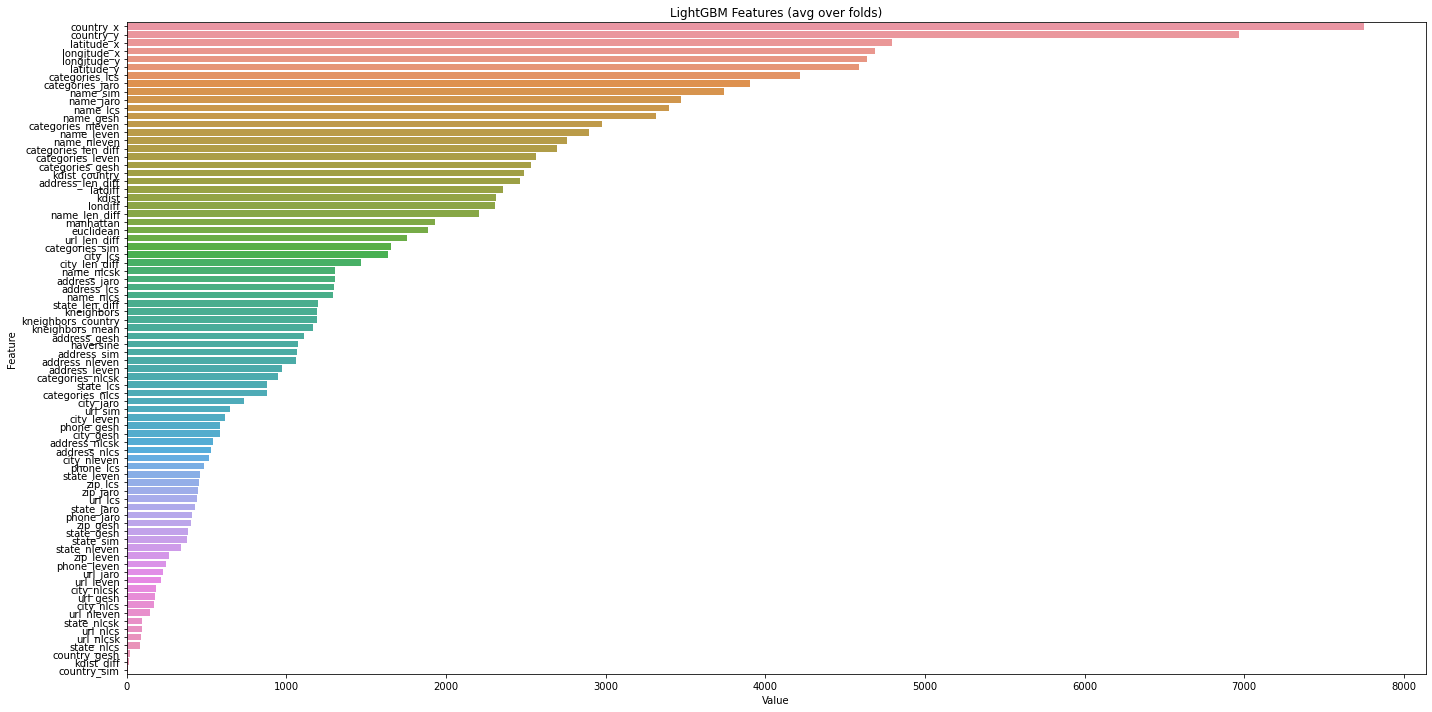

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
import pickle
# save model
#pickle.dump(model, open(f'lgb_{cv}.pkl', 'wb'))
pickle.dump(model, open(f'lgb_0.pkl', 'wb'))


### Check
- メトリクスの目安となる値を求める

In [29]:
pred = model.predict(valid_x, num_iteration=model.best_iteration)

In [30]:
model.params

{'bagging_fraction': 0.880696646905474,
 'bagging_freq': 1,
 'feature_fraction': 0.5479999999999999,
 'feature_pre_filter': False,
 'lambda_l1': 6.487776074079757e-05,
 'lambda_l2': 9.333101753406423,
 'learning_rate': 0.05,
 'metric': 'auc',
 'min_child_samples': 20,
 'num_leaves': 118,
 'objective': 'binary',
 'random_state': 0}

In [31]:
model.best_iteration

716

In [32]:
len(pred)

3542568

In [33]:
pred.mean()

0.025763222701718054

In [34]:
valid['pred'] = pred

In [35]:
valid_tmp = valid

In [36]:
valid_tmp = valid_tmp[['id', 'match_id', 'label', 'pred']]

In [37]:
# IoUを計算する時は自分自身も加えるのでuniqueなidを計算しておく
unum = len(valid_tmp['id'].unique())
unum

113881

In [38]:
len(valid_tmp.query('label==1'))

93536

In [39]:
len(valid_tmp.query('pred>0.5'))

79010

In [40]:
for THRESHOLD in (0.4, 0.43, 0.45, 0.47, 0.50):
  print("THRESHOLD=", THRESHOLD, "****************")
  true_num = len(valid_tmp.query('label==1'))
  pred_num = len(valid_tmp.query(f'pred>{THRESHOLD}'))
  a = len(valid_tmp.query(f'label==1 or pred>{THRESHOLD}'))
  b = len(valid_tmp.query(f'label==1 and pred>{THRESHOLD}'))
  print("true_num:", true_num, "pred_num:", pred_num)
  print('a, b=', a, b)
  print('IoU=', (b + unum) / (a + unum))
#print('IoU=', b/a)

THRESHOLD= 0.4 ****************
true_num: 93536 pred_num: 88006
a, b= 110435 71107
IoU= 0.8246759036359421
THRESHOLD= 0.43 ****************
true_num: 93536 pred_num: 85144
a, b= 108816 69864
IoU= 0.8250896958647849
THRESHOLD= 0.45 ****************
true_num: 93536 pred_num: 83396
a, b= 107820 69112
IoU= 0.8254044862224347
THRESHOLD= 0.47 ****************
true_num: 93536 pred_num: 81578
a, b= 106846 68268
IoU= 0.8252230130432616
THRESHOLD= 0.5 ****************
true_num: 93536 pred_num: 79010
a, b= 105544 67002
IoU= 0.8243500056967074


In [ ]:
# all, 6290982
# FP, 50325
# FN, 20183
valid.query(f'label==1 and pred<0.4').head(20) # FP
#valid_tmp.query(f'label==0 and pred>0.8').head(20) # FN

,id,match_id,kdist,kneighbors,kdist_country,kneighbors_country,label,latdiff,londiff,manhattan,...,categories_lcs,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,country_sim,country_gesh,kdist_diff,kneighbors_mean,pred
727,E_00562aa4e4b2db,E_0258802b17b98e,0.0,0.0,0.0,1.0,True,0.0,0.0,0.0,...,4.0,18,0.851852,0.444444,0.148148,1.0,1.0,NaN,0.5,0.051950
1856,E_00dcbf399a3c66,E_e7239abba946fa,0.0,0.0,0.0,10.0,True,0.0,0.0,0.0,...,21.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,5.0,0.006761
4461,E_020e76b9a1aadf,E_87b27e28040119,0.0,0.0,0.0,2.0,True,0.0,0.0,0.0,...,NaN,3,NaN,NaN,NaN,1.0,1.0,NaN,1.0,0.256150
5397,E_0280eae9180255,E_f82a0225911ce9,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,...,7.0,2,0.789474,0.368421,0.411765,1.0,1.0,NaN,0.0,0.343041
9905,E_04852c224633d4,E_e7239abba946fa,0.0,0.0,0.0,10.0,True,0.0,0.0,0.0,...,21.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,5.0,0.008993
19883,E_08fbfae32cfb2a,E_b9e4fe5b4c1fcd,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,...,18.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,0.0,0.318503
20058,E_090faf5df05cd9,E_e015d56f0b43e4,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,...,8.0,25,0.837209,0.444444,0.186047,1.0,1.0,NaN,0.0,0.274122
24529,E_0b0cce8f893902,E_e7239abba946fa,0.0,0.0,0.0,10.0,True,0.0,0.0,0.0,...,21.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,5.0,0.002613
36303,E_105cdb34045e9e,E_b1f51851742c7c,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,...,17.0,36,0.711864,0.288136,0.739130,1.0,1.0,NaN,0.0,0.111018
50765,E_16d4ad61dd5ecb,E_db19ebf794f114,0.0,0.0,0.0,1.0,True,0.0,0.0,0.0,...,12.0,0,0.000000,1.000000,1.000000,1.0,1.0,NaN,0.5,0.259036


In [ ]:
pd.set_option('display.max_columns', 100)
valid.query('id=="E_d0b1c08dc79425" and match_id=="E_2199a9ad89abbe"')

,id,match_id,kdist,kneighbors,kdist_country,kneighbors_country,label,latdiff,londiff,manhattan,euclidean,haversine,latitude_x,latitude_y,longitude_x,longitude_y,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_len_diff,name_nleven,name_nlcsk,name_nlcs,country_x,country_y,address_sim,address_gesh,address_leven,address_jaro,address_lcs,address_len_diff,address_nleven,address_nlcsk,address_nlcs,city_gesh,city_leven,city_jaro,city_lcs,city_len_diff,city_nleven,city_nlcsk,city_nlcs,state_sim,state_gesh,state_leven,state_jaro,state_lcs,state_len_diff,state_nleven,state_nlcsk,state_nlcs,zip_gesh,zip_leven,zip_jaro,zip_lcs,url_sim,url_gesh,url_leven,url_jaro,url_lcs,url_len_diff,url_nleven,url_nlcsk,url_nlcs,phone_gesh,phone_leven,phone_jaro,phone_lcs,categories_sim,categories_gesh,categories_leven,categories_jaro,categories_lcs,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,country_sim,country_gesh,kdist_diff,kneighbors_mean,pred
